## 1. Исследовательский анализ данных

### Предобработка данных

Приступим к изучению данных, поиску пропусков, дубликатов и изменению типов данных.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from functools import reduce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import os
from pathlib import Path
import urllib

Ссылки на датасеты удалены из проекта, чтобы не нарушать авторские права Яндекса.

In [2]:
Path('datasets').mkdir(parents=True, exist_ok=True)

def get_file(file_name, url):
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден и будет загружен из сети')
        _ = urllib.request.urlretrieve(url, file_name)

urls = {
    'contract': ('datasets/contract.csv',
              'https://'),
    'personal': ('datasets/personal.csv',
              'https://'),
    'internet': ('datasets/internet.csv',
              'https://'),
    'phone': ('datasets/phone.csv',
              'https://')
}

[get_file(*urls[k]) for k in urls]

contract, personal, internet, phone = [pd.read_csv(urls[k][0]) for k in urls]

Поменяем `CamelCase` в названии колонок датафреймов на `snake_case`: мы же не джаваскриптеры \\(•◡•)/

In [3]:
def snake_case(column):  
    """Преобразование колонок из camelCase в snake_case"""
    column = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', column).lower()

for df in [contract, personal, internet, phone]:
    df.rename(columns=snake_case, inplace=True)

Определим функцию, выводящую информацию о датафрейме:

In [4]:
def df_info(df):
    df.info()
    display(df.head())
    display(df.describe(include=object))

Перейдем к разбору таблиц

In [5]:
df_info(contract)
print('Способы оплаты: \n', contract.payment_method.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,total_charges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,5,3,2,4,6531
top,9755-JHNMN,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5174,3875,4171,2365,11


Способы оплаты: 
 Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64


Посмотрим, какая есть информация о договорах, актуальная на 1 февраля 2020:

* `customer_id` - уникальный код клиента, всего в базе информация о 7043 клиентах

* `begin_date` - дата заключения договора
* `end_date` - дата окончания договора, если она не указана, будем считать, что клиент еще пользуется услугами «Ниединогоразрыва.ком»
* `type` - способ расчёта клиента: можно платить каждый месяц (month-to-month) или заключить договор на 1–2 года (one year/two year)
* `paperless_billing` - клиент запросил электронный чек, если указано Yes и бумажный, если - No
* `payment_method` - метод оплаты (Electronic check/Mailed check/Bank transfer/Credit card)
* `monthly_charges` - ежемесячные платежи клиента
* `total_charges` - общие расходы клиента

Тип данных `begin_date` и `end_date` надо заменить на Datetime, `total_charges` - на float64

In [6]:
contract[['begin_date', 'end_date']] = (
    contract[['begin_date', 'end_date']].apply(
        pd.to_datetime, errors='coerce'))

contract['total_charges'] = pd.to_numeric(
    contract['total_charges'], errors='coerce')
contract[['begin_date', 'end_date', 'total_charges']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   begin_date     7043 non-null   datetime64[ns]
 1   end_date       1869 non-null   datetime64[ns]
 2   total_charges  7032 non-null   float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 165.2 KB


В столбце `begin_date` не было пропусков, в end_date 5174 пропуска, значит столько клиентов все еще пользуются услугами оператора, в `total_charges` 11 пропусков, посмотрим, что это за пропуски:

In [7]:
contract[contract['total_charges'].isna()]['begin_date'].value_counts()

2020-02-01    11
Name: begin_date, dtype: int64

Видим, что данные о `total_charges` пропущены у тех клиентов, которые присоединились к оператору в дату, на которую собиралась информация о договорах - 1 февраля 2020. Такие данные не помогут обучению модели, так как мы не знаем, на какой срок останутся только что присоединившиеся клиенты - можем их удалить, тем более, что таких всего 11 записей < 1% данных.

In [8]:
contract.dropna(subset=['total_charges'], inplace=True)
contract.reset_index(drop=True)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50
7028,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90
7029,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45
7030,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60


Готово, пропусков нет, из других таблиц эти клиенты удалятся, когда мы будем их мержить.

Добавим в таблицу целевой признак `left`, равный 1, если пользователь ушел, и 0, если пользователь продолжает пользоваться услугами оператора.

In [9]:
contract['left'] = contract['end_date'].notna().astype('int')

Готово, переходим к таблице personal

In [10]:
df_info(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customer_id,gender,partner,dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,9755-JHNMN,Male,No,No
freq,1,3555,3641,4933


Таблица personal содержит персональные данные всех клиентов оператора:
* `customer_id` - уникальный код клиента

* `gender` - пол (Female/Male)
* `senior_citizen` - является ли пенсионером (0/1)
* `partner` - есть ли супруг/супруга (Yes/No)
* `dependents` - есть ли дети (Yes/No)

In [11]:
df_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9755-JHNMN,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Таблица internet содержит данные об интернет-услугах:

* `customer_id` - уникальный код клиента, использующего услуги

* `internet_service` -  тип подключения, может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic)
* `online_security` - наличие/отстутствие услуги "блокировка небезопасных сайтов"
* `online_backup` - наличие/отстутствие услуги "облачное хранилище файлов для резервного копирования данных"
* `device_protection` - наличие/отстутствие услуги "антивирус"
* `tech_support` - наличие/отстутствие услуги "выделенная линия технической поддержки"
* `streaming_tv` - наличие/отстутствие услуги "стриминговое телевидение"
* `streaming_movies` - наличие/отстутствие услуги "каталог фильмов"

In [12]:
df_info(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,9755-JHNMN,No
freq,1,3390


Таблица phone содержит данные об услуге стационарной телефонной связи:
* customer_id - уникальный код клиента, использующего услугу
* multiple_lines - подключен ли телефонный аппарат к нескольким линиям одновременно.

### Кодирование признаков

Объединим все в результирующую таблицу, чтобы комплексно смотреть на данные. Поскольку у нас есть клиенты, использующие и интернет, и телефонию, то и предсказывать их уход нужно, опираясь на всю информацию, а не отдельно для интернета и телефонии. Возможно, клиент, недовольный интернетом перестанет пользоваться и телефонией нормального качества.

In [13]:
clean_data = (contract.merge(personal, on='customer_id', how='left')
              .merge(internet, on='customer_id', how='left')
              .merge(phone, on='customer_id', how='left'))

Для обучения модели сгенерируем фичу:
- `ltv` время жизни клиента

День в расчет не берем, так как данные всегда от 1 числа.

In [14]:
clean_data['ltv'] = (clean_data['end_date'].fillna(
    pd.to_datetime('2020-02-01')) - clean_data['begin_date']
                    ).dt.days

Удалим признаки, которые не получится использовать при обучении и заполним все пропуски -1

In [15]:
clean_data.drop(columns=['customer_id', 'begin_date', 'end_date'],
                inplace=True, errors='ignore')
clean_data.fillna(-1, inplace=True)

Большинтсво признаков бинарное, категориальные признаки преобразуем в численные методом OHE, так как Ordinal Encoding не подходит для логистической регрессии, а OHE работает со всеми моделями. Поскольку  новые столбцы сильно связаны между собой, первый удалим с помощью drop_first=True, восстановить его можно по оставшимся, так мы не попадём в дамми-ловушку.

In [16]:
clean_data = pd.get_dummies(clean_data, drop_first=True)

In [17]:
clean_data

,monthly_charges,total_charges,left,senior_citizen,ltv,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,...,device_protection_No,device_protection_Yes,tech_support_No,tech_support_Yes,streaming_tv_No,streaming_tv_Yes,streaming_movies_No,streaming_movies_Yes,multiple_lines_No,multiple_lines_Yes
0,29.85,29.85,0,0,31,0,0,1,0,1,...,1,0,1,0,1,0,1,0,0,0
1,56.95,1889.50,0,0,1036,1,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
2,53.85,108.15,1,0,61,0,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
3,42.30,1840.75,0,0,1371,1,0,0,0,0,...,0,1,0,1,1,0,1,0,0,0
4,70.70,151.65,1,0,61,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,84.80,1990.50,0,0,730,1,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1
7028,103.20,7362.90,0,0,2191,1,0,1,1,0,...,0,1,1,0,0,1,0,1,0,1
7029,29.60,346.45,0,0,337,0,0,1,0,1,...,1,0,1,0,1,0,1,0,0,0
7030,74.40,306.60,1,1,123,0,0,1,0,0,...,1,0,1,0,1,0,1,0,0,1


Данные предобработаны, датасет чистенький)

### Анализ графиков

Посмотрим на характерный разброс данных об оплатах клиентов

<AxesSubplot:xlabel='left', ylabel='total_charges'>

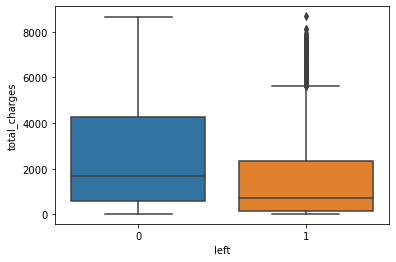

In [18]:
sns.boxplot(x='left', y="total_charges", data=clean_data)

<AxesSubplot:xlabel='left', ylabel='monthly_charges'>

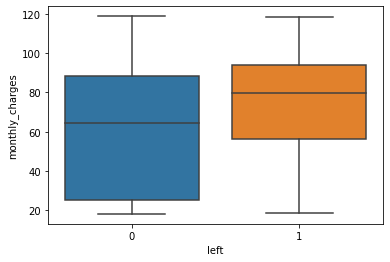

In [19]:
sns.boxplot(x='left', y="monthly_charges", data=clean_data)

Ушедшие клиенты, в среднем, суммарно платят меньше, что интуитивно понятно, а их средние помесячные платежи выше (на следующем шаге проверим, значима ли статистически эта разница). Возможно, причина их ухода - плохо подобранный тариф

<AxesSubplot:ylabel='left'>

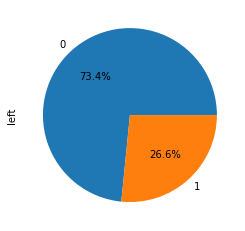

In [20]:
clean_data['left'].value_counts().plot.pie(autopct="%.1f%%")

Это что тут у нас - это дисбаланс у целевого признака: в датасете почти в 3 раза больше данных о клиентах, не покинувших оператора. Поборемся с ним на следующем шаге.

Посмотрим на матрицу корреляций для количественных факторов

In [21]:
display(clean_data[['monthly_charges', 'total_charges', 'ltv']].corr())
clean_data.drop(columns=['total_charges'],
                inplace=True, errors='ignore')

,monthly_charges,total_charges,ltv
monthly_charges,1.000000,0.651065,0.246715
total_charges,0.651065,1.000000,0.825811
ltv,0.246715,0.825811,1.000000


Когда количественные факторы имеют сильную корреляцию друг с другом - больше 0.8, нужно удалить лишнее, в нашем случае столбец - total_charges, поскольку суммарные выплаты - это произведение месячных выплат на время жизни клиента в месяцах с небольшим отклонением у некоторых клиентов, вызванным, возможно, пенями или чем-то подобным.

<AxesSubplot:xlabel='left', ylabel='ltv'>

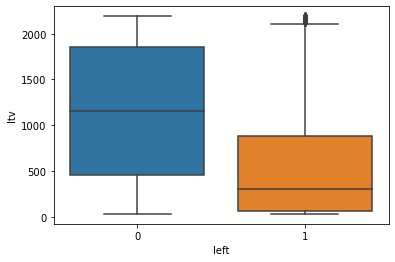

In [22]:
sns.boxplot(x='left', y='ltv', data=clean_data)

Видим, что среди ушедших (left=1) большинство тех, кто с оператором недавно (гипотеза проверена на следующем шаге). Для обучения важно, чтобы в датасете были представлены данные о клиентах, которые недавно с оператором, но все еще пользуются его услугами, проверим это.

<AxesSubplot:ylabel='left'>

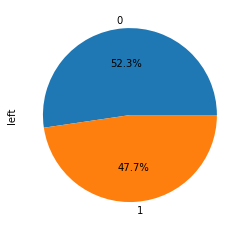

In [23]:
clean_data[clean_data['ltv'] <= 365]['left'].value_counts().plot.pie(autopct="%.1f%%")

Среди клиентов, которые с оператором до года, примерно поровну ушедших и оставшихся - в этом смысле датасет сбалансирован.

<AxesSubplot:ylabel='left'>

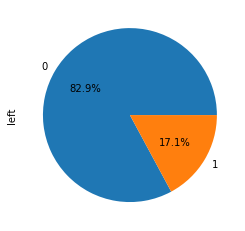

In [24]:
clean_data[clean_data['ltv'] > 365]['left'].value_counts().plot.pie(autopct="%.1f%%")

А среди клиентов, которые с оператором больше года, почти в 5 раз больше тех, которые не уходят. Предсказывать клиентов, которые с оператором давно, но хотят уйти, будет сложнее.

### Аналитические методы проверки гипотез
#### Гипотеза о равенстве средних ltv ушедших и оставшихся клиентов
Разделим данные на 2 датасета: ltv ушедших и оставшихся клиентов. Проверим гипотезу о равенстве ltv двух групп пользователей.

In [25]:
left_customer_ltv = clean_data[clean_data['left'] == 1]['ltv']
customer_ltv = clean_data[clean_data['left'] == 0]['ltv']
print('Дисперсия времени жизни ушедших клиентов', np.var(left_customer_ltv))
print('Дисперсия времени жизни оставшихся клиентов', np.var(customer_ltv))
print('Медианное время жизни ушедших клиентов', left_customer_ltv.median())
print('Медианное время жизни оставшихся клиентов', customer_ltv.median())

Дисперсия времени жизни ушедших клиентов 353109.9734320864
Дисперсия времени жизни оставшихся клиентов 536852.9396376542
Медианное время жизни ушедших клиентов 304.0
Медианное время жизни оставшихся клиентов 1157.0


Медианное время жизни оставшихся с оператором клиентов почти в 4 раза превышает медианное время жизни ушедших клиентов. Проверим, значима ли статистически эта разница.

Исходя из того, что нулевая гипотеза всегда формулирует равенство чего-то, а альтернативная может формулироваться как не равно, сформулируем нулевую гипотезу H₀ и альтернативную гипотезу H₁:

- H₀: Среднее время жизни ушедших клиентов равно среднему времени жизни оставшихся.
- H₁: Среднее время жизни ушедших клиентов не равно среднему времени жизни оставшихся.

Критический уровень статистической значимости зададим значением 0.05. Дисперсии двух выборок различаются более чем на 5%, поэтому добавим в параметры теста equal_var = False.

In [26]:
def ttest_ind(sample_1, sample_2):
    alpha = .05
    results = st.ttest_ind(sample_1, sample_2, equal_var = False)
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
        
ttest_ind(left_customer_ltv, customer_ltv)

p-значение: 5.881089741944088e-235
Отвергаем нулевую гипотезу


Очень низкое значение p-value говорит о том, что вероятность получить наблюдаемый результат при условии, что нулевая гипотеза верна, очень низкая. Другими словами, вероятность получить H₁ случайно очень низкая, значит, с большой долей вероятности, H₁ не случайна. Таким образом, мы отвергаем нулевую гипотезу.

С вероятностью более 99% среднее время жизни ушедших клиентов отличается от среднего времени жизни оставшихся.

#### Гипотеза о равенстве средних помесячных платежей оставшихся и ушедших клиентов
Аналогично проверим выше ли средние помесячные платежи у ушедших клиентов.

- H₀: Средний помесячный платеж ушедших клиентов равен среднему помесячному платежу оставшихся.
- H₁: Средний помесячный платеж ушедших клиентов не равен среднему помесячному платежу оставшихся.

In [27]:
print('Дисперсия помесячных платежей ушедших клиентов', np.var(left_customer_ltv))
print('Дисперсия помесячных платежей оставшихся клиентов', np.var(customer_ltv))
print('Медианный помесячный платеж ушедших клиентов', left_customer_ltv.median())
print('Медианный помесячный платеж оставшихся клиентов', customer_ltv.median())
left_customer_mc = clean_data[clean_data['left'] == 1]['monthly_charges']
customer_mc = clean_data[clean_data['left'] == 0]['monthly_charges']
ttest_ind(left_customer_mc, customer_mc)

Дисперсия помесячных платежей ушедших клиентов 353109.9734320864
Дисперсия помесячных платежей оставшихся клиентов 536852.9396376542
Медианный помесячный платеж ушедших клиентов 304.0
Медианный помесячный платеж оставшихся клиентов 1157.0
p-значение: 2.657357144516026e-72
Отвергаем нулевую гипотезу


Можем сделать вывод, что с вероятностью более 99% средний ежемесячный платеж ушедших клиентов отличается от среднего ежемесячного платежа оставшихся.

## 2. Обучение модели

In [28]:
# зафиксируем значение параметра random_state, чтобы результаты нашей работы были воспроизводимы
state = 12345

In [29]:
#отделим целевой признак
target = clean_data['left']
features = clean_data.drop(['left'], axis=1)

Данные разбиваем только на 2 выборки: обучающую и тестовую, валидационная будет генерироваться на этапе кросс-валидации. Исходные данные разбиваем в соотношении 4:1 (80%:20%) стратифицированным способом, чтобы в обеих частях сохранялась одинаковая доля пользователей, покинувших оператора.

In [30]:
target_train, target_test, features_train, features_test = train_test_split(
    target, features, random_state=state, test_size=.2, stratify=target)

Для начала попробуем простые модели: случайный лес, логистическую регрессию и дерево принятия решений. Для подбора гиперпараметров используем GridSearchCV, чтобы полученная метрика была более стабильна на тестовой выборке

In [31]:
scaler = ColumnTransformer(transformers=[(
    'std', StandardScaler(),
     ['monthly_charges', 'ltv'])],
    remainder='passthrough')
pipe_lr = Pipeline(steps=[('scale', scaler),
                          ('lr', LogisticRegression(max_iter=10000, tol=0.1,
                                                    random_state=state))])

pipe_dt = Pipeline(steps=[('dt', DecisionTreeClassifier(random_state=state))])
pipe_rf = Pipeline(steps=[('forest', RandomForestClassifier(random_state=state))])

Для логистической регрессии необходимо масштабирование признаков - используем структуру StandardScaler, настраиваем скейлер внутри пайплайна, чтобы масштабирование данных проходило только на обучающих данных и не содержало данных о масштабе валидационных.

In [32]:
grid_params_rf = {'forest__n_estimators': range(1,100,10),
                  'forest__max_depth': range(1,10,1),
                  'forest__class_weight': ['balanced_subsample'],
                  'forest__criterion': ['gini', 'entropy']}

grid_params_lr = {'lr__penalty': ['l1', 'l2'],
                  'lr__C': [1.0, 0.5],
                  'lr__solver': ['liblinear'],
                  'lr__class_weight': ['balanced']}

grid_params_dt = {'dt__criterion': ['gini', 'entropy'],
                  'dt__max_depth': range(1,10),
                  'dt__class_weight': ['balanced']}

RF = GridSearchCV(pipe_rf, grid_params_rf,
                  cv=3, scoring='roc_auc')

LR = GridSearchCV(pipe_lr, grid_params_lr,
                  cv=3, scoring='roc_auc')

DT = GridSearchCV(pipe_dt, grid_params_dt,
                  cv=3, scoring='roc_auc')

Добавим взвешивание классов, т.е. придадим объектам редкого класса больший вес, так как алгоритмы машинного обучения считают все объекты обучающей выборки равнозначными по умолчанию. Параметр class_weight есть у всех трех используемых нами моделей, если указать class_weight='balanced', то больший вес будет у редкого класса. Переходим к обучению

In [33]:
%%time

grids = [RF, LR, DT]

grid_dict = {0: 'Random Forest', 
             1: 'Logistic Regression',
             2: 'Decision Tree'}

metrics_df = pd.DataFrame()

for i, grid in enumerate(grids):
    grid.fit(features_train, target_train)
    metrics_df = metrics_df.append(pd.Series(
        [grid_dict[i], grid.best_score_, 
         accuracy_score(target_train, grid.predict(features_train)),
         grid.score(features_train, target_train),
         accuracy_score(target_test, grid.predict(features_test)),
         grid.score(features_test, target_test)]),
                                   ignore_index=True)

metrics_df.columns=['model', 'AUC-ROC best cross-val',
                    'accuracy train', 'AUC-ROC train',
                    'accuracy test', 'AUC-ROC test']
metrics_df

CPU times: user 1min, sys: 729 ms, total: 1min 1s
Wall time: 59.4 s


,model,AUC-ROC best cross-val,accuracy train,AUC-ROC train,accuracy test,AUC-ROC test
0,Random Forest,0.850839,0.788622,0.887105,0.771855,0.861922
1,Logistic Regression,0.841225,0.749333,0.844007,0.760483,0.850885
2,Decision Tree,0.837502,0.773511,0.874018,0.769723,0.857486


Хорошо, но не достаточно хорошо, попробуем более сложную модель - CatBoostClassifier

In [34]:
%%time

cat_boost = CatBoostClassifier(loss_function="Logloss",
                               verbose=0)
grid_params_cbc = {'learning_rate': [0.03, 0.1],
                   'depth': [5, 10]}

CBC = GridSearchCV(cat_boost, grid_params_cbc,
                   cv=3, scoring='roc_auc')
CBC.fit(features_train, target_train)

metrics_df = metrics_df.append(pd.Series([
    'CatBoostClassifier',
    CBC.best_score_,
    accuracy_score(target_train, CBC.predict(features_train)),
    CBC.score(features_train, target_train),
    accuracy_score(target_test, CBC.predict(features_test)),
    CBC.score(features_test, target_test)],
    index=metrics_df.columns),
                  ignore_index=True)

CPU times: user 3min 31s, sys: 14.4 s, total: 3min 45s
Wall time: 1min 17s


In [35]:
metrics_df

,model,AUC-ROC best cross-val,accuracy train,AUC-ROC train,accuracy test,AUC-ROC test
0,Random Forest,0.850839,0.788622,0.887105,0.771855,0.861922
1,Logistic Regression,0.841225,0.749333,0.844007,0.760483,0.850885
2,Decision Tree,0.837502,0.773511,0.874018,0.769723,0.857486
3,CatBoostClassifier,0.909419,0.966578,0.995433,0.884861,0.926390


In [36]:
print('Точность CatBoostClassifier на тестовой выборке',
      precision_score(target_test, CBC.predict(features_test)))
print('Полнота CatBoostClassifier на тестовой выборке',
      recall_score(target_test, CBC.predict(features_test)))

Точность CatBoostClassifier на тестовой выборке 0.8375796178343949
Полнота CatBoostClassifier на тестовой выборке 0.7032085561497327


Таким образом, наилучшее качество у модели CatBoostClassifier:

значение метрик на тестовой выборке:

* AUC-ROC - 0.93
* accuracy - 0.88
* precision - 0.84
* recall - 0.7

Проверим модель на адекватность с помощью DummyClassifier, генерирующего предсказания с учетом распределения классов обучающей выборки.

In [37]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(features_train, target_train)
dummy_predictions = dummy_clf.predict(features_test)
print('Значение метрики AUC-ROC случайной модели на тестовой выборке: %.3f ' % 
      roc_auc_score(target_test, dummy_clf.predict_proba(features_test)[:, 1]))
print('Значение метрики accuracy случайной модели на тестовой выборке: %.3f ' % 
      accuracy_score(target_test, dummy_predictions))

Значение метрики AUC-ROC случайной модели на тестовой выборке: 0.505 
Значение метрики accuracy случайной модели на тестовой выборке: 0.615 


Как видим, значение accuracy и AUC-ROC хуже полученной нами метрики.

### Анализ важности факторов модели

Перейдем к анализу важности факторов с помощью команды  feature_importances_

In [38]:
catboost_importances = pd.Series(CBC.best_estimator_.feature_importances_, index=features_train.columns)
catboost_importances = catboost_importances.sort_values(ascending=False)

Text(0, 0.5, 'FEATURE NAMES')

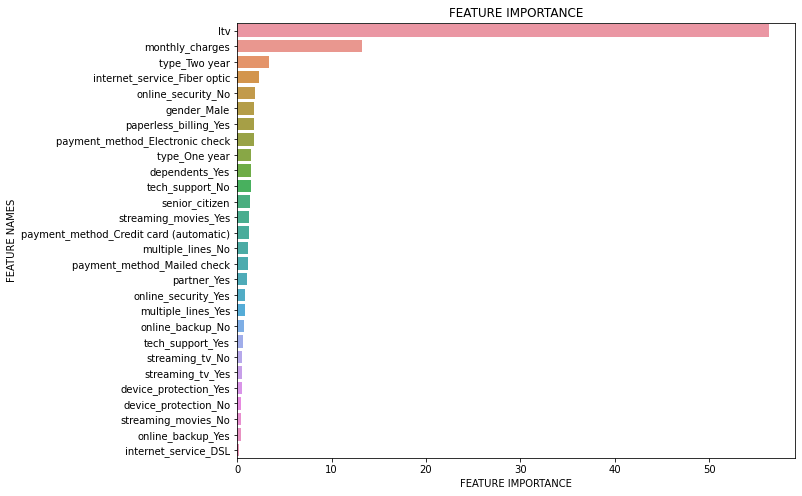

In [39]:
plt.figure(figsize=(10,8))
sns.barplot(x=catboost_importances.values, y=catboost_importances.index)
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

Видим, что наиболее важные признаки для модели CatBoostClassifier - время жизни клиента, размер месячной оплаты, срок договора, тип подключения к интернету, подключена ли услуга блокировки небезопасных сайтов.

Слабозначимы для модели, т.е. незначительно влияют на целевую переменную следующие признаки:
* использует ли клиент облачное хранилище файлов для резервного копирования данных 
* антивирус
* cтриминговое телевидение и каталог фильмов
* выделенная линия технической поддержки
* подключен ли клиент через телефонную линию
* подключен ли телефонный аппарат к нескольким линиям одновременно
* есть ли супруг/супруга

Эти признаки смело можно убирать из модели - они не влияют на уход клиента.

## 3. Вывод

На основе персональных данных пользователей, а также данных об их тарифах и договорах была построена модель для задачи классификации, которая может спрогнозировать, уйдёт клиент от оператора в ближайшее время или нет.

Наилучшие метрики качества на тестовой выборке показал CatBoostClassifier:
* AUC-ROC - 0.92
* accuracy - 0.88
* precision - 0.84
* recall - 0.7

Наиболее важные признаки для этой модели - время жизни клиента, размер месячной оплаты и срок договора.

На уход клиента не влияет использует ли он:
* облачное хранилище файлов для резервного копирования данных 
* антивирус
* cтриминговое телевидение и каталог фильмов
* выделенная линия технической поддержки
* подключен ли клиент через телефонную линию
* подключен ли телефонный аппарат к нескольким линиям одновременно
* есть ли у него супруг/супруга

Таким образом, модель поможет сохранять текущих клиентов: если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.